Calculate SHAP value for all o1-generated rules

In [ ]:

import os
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
import shap

seed = 42
DIR = 'yield_o1'
target_name = 'yield'


data = pd.read_csv("agent/data/data.csv")[['SMILES','Fe_loading','modifier/SBU']]
# Container to store the results
all_shap_results = []

train_accuracy = []
val_accuracy = []

# test_preds = []
# test_trues = []
# Iterate over each split value
for _ in range(1, 37):
    
    print(f'LOO {_}')
    folder = os.path.join(DIR,str(_))
    train_set = pd.read_csv(os.path.join(folder,"train_set.csv"))
    test_set = pd.read_csv(os.path.join(folder,"test_set.csv"))
    train_set = train_set.merge(data,on='SMILES',how='left')
    test_set = test_set.merge(data,on='SMILES',how='left')
    
    train_matrix = pd.read_csv(os.path.join(folder,'best_train_matrix.csv'))
    rule_title = ['LOO_'+str(_)+"_"+x for x in train_matrix.columns.values]+['Fe_loading','modifier/SBU']
    train_matrix = pd.concat([train_matrix,train_set[['Fe_loading','modifier/SBU']]],axis=1)
    # test_matrix = pd.read_csv(os.path.join(folder,'best_test_mtx.csv'))
    model_cla = RandomForestClassifier(n_estimators=500, random_state=seed,n_jobs=64)
    
    tar_column_name = f'{target_name}_high_or_low_value'
    train_labels = train_set[tar_column_name]
    
    
    loo = LeaveOneOut()
    selector = RFECV(model_cla, step=1, cv=loo, scoring='accuracy',n_jobs=64)
    
    selector.fit(train_matrix.values, train_labels.values)

    selection = selector.support_
    selected_train_matrix = train_matrix.iloc[:,selection]
    # selected_test_matrix = test_matrix.iloc[:,selection]
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    rule_shap = []
    
    train_preds = []
    train_trues = []
    val_preds = []
    val_trues = []
    
    for train_idx, val_idx in skf.split(selected_train_matrix,train_labels):
        tr_features,val_features = selected_train_matrix.iloc[train_idx],selected_train_matrix.iloc[val_idx]
        tr_labels,val_labels = train_labels.iloc[train_idx],train_labels.iloc[val_idx]

        model_cla = model_cla
        model_cla.fit(tr_features.values, tr_labels.values)
        tra_cla_predictions = model_cla.predict(tr_features.values)
        val_cla_predictions = model_cla.predict(val_features.values)
        
        train_preds.extend(tra_cla_predictions)
        train_trues.extend(tr_labels.values)
        val_preds.extend(val_cla_predictions)
        val_trues.extend(val_labels.values)
        # val_accuracy = accuracy_score(val_labels.values, val_cla_predictions)
        explainer = shap.TreeExplainer(model_cla)
        val_shap_values = explainer.shap_values(val_features.values)
        rule_shap.extend(val_shap_values[:,:,1])
    
    mean_rule_shap = np.array(rule_shap)
    mean_rule_shap = np.mean(mean_rule_shap,axis=0)
    train_accuracy.append(accuracy_score(train_trues, train_preds))
    val_accuracy.append(accuracy_score(val_trues, val_preds))
    print(f"train_accuracy: {accuracy_score(train_trues, train_preds)}")
    print(f"val_accuracy: {accuracy_score(val_trues, val_preds)}")
    # Organize SHAP values alongside rule titles
    rule_title = [rule_title[i] for i in range(len(rule_title)) if selection[i]]
    shap_df = pd.DataFrame({
        'Rule': rule_title,
        'Mean_SHAP_Value': mean_rule_shap
    })
    shap_df['Split'] = _  # Annotate with the split index
    all_shap_results.append(shap_df)
print("-"*50)
print("Final Metric")
print(f"Mean_train_accuracy: {np.mean(train_accuracy)}")
print(f"Mean_val_accuracy: {np.mean(val_accuracy)}")
# print(f"Mean_test_accuracy: {np.mean(test_accuracy)}")
# Combine all results
full_shap_df = pd.concat(all_shap_results, ignore_index=True)

# Save the concatenated dataframe to CSV
full_shap_df.to_csv('o1_rules_SHAP_value/mean_shap_values.csv', index=False)

LOO 1
train_accuracy: 1.0
val_accuracy: 0.8571428571428571
LOO 2
train_accuracy: 1.0
val_accuracy: 0.7714285714285715
LOO 3
train_accuracy: 1.0
val_accuracy: 0.8285714285714286
LOO 4
train_accuracy: 1.0
val_accuracy: 0.8285714285714286
LOO 5
train_accuracy: 1.0
val_accuracy: 0.8857142857142857
LOO 6
train_accuracy: 1.0
val_accuracy: 0.8571428571428571
LOO 7
train_accuracy: 1.0
val_accuracy: 0.8571428571428571
LOO 8
train_accuracy: 1.0
val_accuracy: 0.8571428571428571
LOO 9
train_accuracy: 1.0
val_accuracy: 0.8285714285714286
LOO 10
train_accuracy: 1.0
val_accuracy: 0.8285714285714286
LOO 11
train_accuracy: 1.0
val_accuracy: 0.8571428571428571
LOO 12
train_accuracy: 1.0
val_accuracy: 0.8285714285714286
LOO 13
train_accuracy: 1.0
val_accuracy: 0.7714285714285715
LOO 14
train_accuracy: 1.0
val_accuracy: 0.7142857142857143
LOO 15
train_accuracy: 1.0
val_accuracy: 0.7142857142857143
LOO 16
train_accuracy: 1.0
val_accuracy: 0.8571428571428571
LOO 17
train_accuracy: 1.0
val_accuracy: 0.771428

Distribution of absolute SHAP values

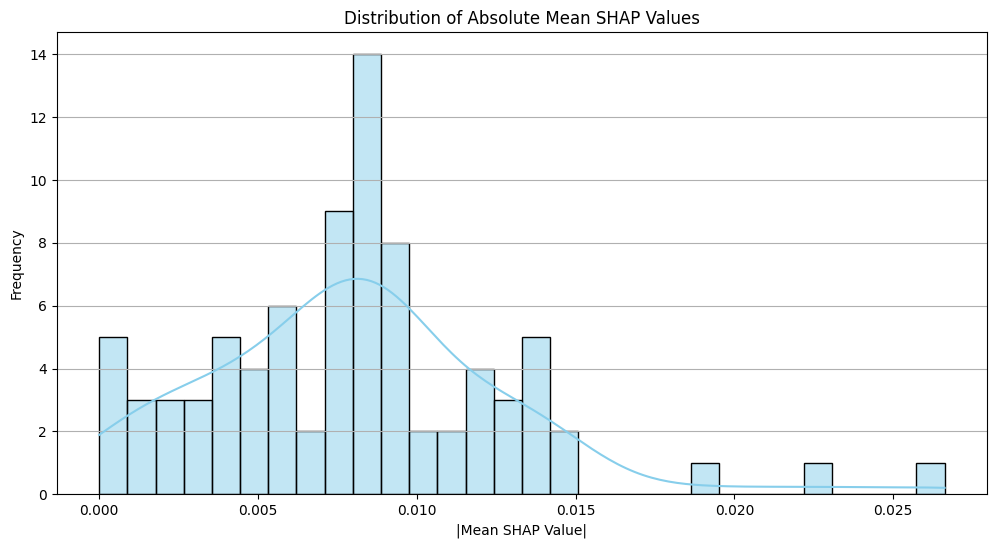

Top 20 Rules by Absolute Mean SHAP Value:
                 Rule  Abs_Mean_SHAP_Value
132     LOO_30_Rule 2             0.026620
128     LOO_29_Rule 9             0.022673
118     LOO_24_Rule 2             0.018975
1       LOO_1_Rule 15             0.015031
67      LOO_12_Rule 6             0.014284
78      LOO_14_Rule 5             0.014091
34     LOO_8_Rule 8.1             0.014085
23       LOO_7_Rule 2             0.013864
103     LOO_19_Rule 5             0.013734
69   LOO_12_Rule 12.1             0.013435
114     LOO_23_Rule 6             0.013189
54      LOO_10_Rule 8             0.013100
6        LOO_3_Rule 1             0.013072
81      LOO_14_Rule 9             0.012293
7        LOO_3_Rule 2             0.011942
49      LOO_10_Rule 2             0.011786
59      LOO_11_Rule 3             0.011660
31       LOO_8_Rule 5             0.011454
143    LOO_32_Rule 14             0.011104
65      LOO_12_Rule 4             0.010191


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the SHAP data
shap_data = pd.read_csv("o1_rules_SHAP_value/mean_shap_values.csv")

# Filter out features called 'Fe_loading'
shap_data = shap_data[~shap_data['Rule'].str.contains('Fe_loading', case=False, na=False)]
shap_data = shap_data[~shap_data['Rule'].str.contains('modifier/SBU', case=False, na=False)]
# Calculate absolute mean SHAP values
shap_data['Abs_Mean_SHAP_Value'] = shap_data['Mean_SHAP_Value'].abs()

# Plot the distribution of absolute mean SHAP values
plt.figure(figsize=(12, 6))
sns.histplot(shap_data['Abs_Mean_SHAP_Value'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Absolute Mean SHAP Values')
plt.xlabel('|Mean SHAP Value|')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

# Sort by absolute mean SHAP value to identify top 20 features
top_20_shap = shap_data.nlargest(20, 'Abs_Mean_SHAP_Value')

# Save the top 20 SHAP feature names to a file
top_20_features = top_20_shap['Rule'].tolist()
with open('o1_rules_SHAP_value/top_20_shap_features.txt', 'w') as f:
    for feature in top_20_features:
        f.write(f"{feature}\n")

# Display the top 20 rules with absolute mean SHAP values
print("Top 20 Rules by Absolute Mean SHAP Value:")
print(top_20_shap[['Rule', 'Abs_Mean_SHAP_Value']])

Save the absolute value and record the top 20 significant rules

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the SHAP data
shap_data = pd.read_csv("o1_rules_SHAP_value/mean_shap_values.csv")

# Calculate absolute mean SHAP values
shap_data['Abs_Mean_SHAP_Value'] = shap_data['Mean_SHAP_Value'].abs()


# Sort by absolute mean SHAP value
top_20_shap = shap_data.nlargest(len(shap_data), 'Abs_Mean_SHAP_Value')

# Display the top 20 rules with absolute mean SHAP values
print("Top 20 Rules by Absolute Mean SHAP Value:")
print(top_20_shap[['Rule', 'Abs_Mean_SHAP_Value']])
top_20_shap.to_csv("o1_rules_SHAP_value/all_shap.csv",index=None)

Top 20 Rules by Absolute Mean SHAP Value:
                 Rule  Abs_Mean_SHAP_Value
125        Fe_loading             0.042959
132     LOO_30_Rule 2             0.026620
123        Fe_loading             0.026206
129        Fe_loading             0.025840
112      modifier/SBU             0.023431
..                ...                  ...
61      LOO_11_Rule 8             0.000826
45      LOO_9_Rule 15             0.000808
134     LOO_30_Rule 5             0.000378
104     LOO_19_Rule 6             0.000251
71   LOO_12_Rule 15.1             0.000000

[154 rows x 2 columns]


Generate rule matrix using the best codes of each splitting

In [5]:
import pandas as pd
from rdkit import Chem
import os
all_smiles = list(pd.read_csv("agent/data/data.csv")['SMILES'])


seed = 42
DIR = 'yield_o1'
target_name = 'yield'

all_best_features = pd.DataFrame({
    'Index':[x for x in range(1,37)]
})
# _ = 1
for _ in range(1, 37):
    print(f'LOO {_}')
    folder = os.path.join(DIR,str(_))
    code_file = os.path.join(folder,"best_rule_code.txt")
    with open(code_file) as f:
        code = f.read()
    exec(code, globals())
    df = rule2matrix(all_smiles) # type: ignore
    selected_train_matrix = pd.read_csv(os.path.join(folder,'best_train_matrix.csv'))
    selected_test_matrix = pd.read_csv(os.path.join(folder,'best_test_matrix.csv'))
    # # model_cla = ExtraTreesClassifier(n_estimators=500, random_state=seed,n_jobs=64)
    selected_rules = list(selected_train_matrix.columns.values)
    df = df[selected_rules]
    # print(selected_rules)
    rule_title = ['LOO_'+str(_)+"_"+x for x in selected_train_matrix.columns.values]
    df.columns = rule_title
    all_best_features = pd.concat([all_best_features,df],axis=1)



LOO 1
LOO 2
LOO 3


[21:51:14] SMARTS Parse Error: syntax error while parsing: [NX3][CX4][CX4]{1,3}[CX3](=O)[O;H1,H0-]
[21:51:14] SMARTS Parse Error: Failed parsing SMARTS '[NX3][CX4][CX4]{1,3}[CX3](=O)[O;H1,H0-]' for input: '[NX3][CX4][CX4]{1,3}[CX3](=O)[O;H1,H0-]'
[21:51:14] SMARTS Parse Error: syntax error while parsing: [SX2H][CX4][CX2,CX4]{0,4}[CX3](=O)[O;H1,H0-]
[21:51:14] SMARTS Parse Error: Failed parsing SMARTS '[SX2H][CX4][CX2,CX4]{0,4}[CX3](=O)[O;H1,H0-]' for input: '[SX2H][CX4][CX2,CX4]{0,4}[CX3](=O)[O;H1,H0-]'
[21:51:14] SMARTS Parse Error: syntax error while parsing: [OX2][CX2,CX3]([OX2][CX2,CX3]){1,}[O,N;H1]
[21:51:14] SMARTS Parse Error: Failed parsing SMARTS '[OX2][CX2,CX3]([OX2][CX2,CX3]){1,}[O,N;H1]' for input: '[OX2][CX2,CX3]([OX2][CX2,CX3]){1,}[O,N;H1]'
[21:51:14] SMARTS Parse Error: syntax error while parsing: [CX3](=O)[CX2]{1,}[CX3](=O)
[21:51:14] SMARTS Parse Error: Failed parsing SMARTS '[CX3](=O)[CX2]{1,}[CX3](=O)' for input: '[CX3](=O)[CX2]{1,}[CX3](=O)'
[21:51:14] SMARTS Parse 

LOO 4
LOO 5
LOO 6
LOO 7
LOO 8
LOO 9


[21:51:14] SMARTS Parse Error: syntax error while parsing: C[CX3](=O)[OX2H1]|CC[CX3](=O)[OX2H1]
[21:51:14] SMARTS Parse Error: Failed parsing SMARTS 'C[CX3](=O)[OX2H1]|CC[CX3](=O)[OX2H1]' for input: 'C[CX3](=O)[OX2H1]|CC[CX3](=O)[OX2H1]'
[21:51:14] SMARTS Parse Error: syntax error while parsing: CC[C@H](N)C1=CC=CC=C1|CC[C@H](N)C1=CC=C2C=CC=CN12
[21:51:14] SMARTS Parse Error: Failed parsing SMARTS 'CC[C@H](N)C1=CC=CC=C1|CC[C@H](N)C1=CC=C2C=CC=CN12' for input: 'CC[C@H](N)C1=CC=CC=C1|CC[C@H](N)C1=CC=C2C=CC=CN12'


LOO 10
LOO 11
LOO 12


[21:51:14] SMARTS Parse Error: syntax error while parsing: [c][c](c[c][c][c])[$(F)_100
[21:51:14] SMARTS Parse Error: Failed parsing SMARTS '[c][c](c[c][c][c])[$(F)_100' for input: '[c][c](c[c][c][c])[$(F)'
[21:51:14] SMARTS Parse Error: syntax error while parsing: $(Cl)_100
[21:51:14] SMARTS Parse Error: Failed parsing SMARTS '$(Cl)_100' for input: '$(Cl)'
[21:51:14] SMARTS Parse Error: syntax error while parsing: $(Br)_100
[21:51:14] SMARTS Parse Error: Failed parsing SMARTS '$(Br)_100' for input: '$(Br)'
[21:51:14] SMARTS Parse Error: syntax error while parsing: $(I)_100
[21:51:14] SMARTS Parse Error: Failed parsing SMARTS '$(I)_100' for input: '$(I)'
[21:51:14] SMARTS Parse Error: syntax error while parsing: [CX4](F)(F)F]
[21:51:14] SMARTS Parse Error: Failed parsing SMARTS '[CX4](F)(F)F]' for input: '[CX4](F)(F)F]'
[21:51:14] SMARTS Parse Error: syntax error while parsing: [c][c](c[c][c][c])[$(O[CH3])_100
[21:51:14] SMARTS Parse Error: Failed parsing SMARTS '[c][c](c[c][c][c])[$(O

LOO 13
LOO 14
LOO 15
LOO 16
LOO 17
LOO 18
LOO 19
LOO 20


[21:51:15] SMARTS Parse Error: syntax error while parsing: c1cc([CX3H=O])ccc1C(=O)[OX2H1]
[21:51:15] SMARTS Parse Error: Failed parsing SMARTS 'c1cc([CX3H=O])ccc1C(=O)[OX2H1]' for input: 'c1cc([CX3H=O])ccc1C(=O)[OX2H1]'
[21:51:15] SMARTS Parse Error: syntax error while parsing: c1cc([CX3H=O])ccc1C(=O)[OX2H1]
[21:51:15] SMARTS Parse Error: Failed parsing SMARTS 'c1cc([CX3H=O])ccc1C(=O)[OX2H1]' for input: 'c1cc([CX3H=O])ccc1C(=O)[OX2H1]'
[21:51:15] SMARTS Parse Error: syntax error while parsing: c1cc([CX3H=O])ccc1C(=O)[OX2H1]
[21:51:15] SMARTS Parse Error: Failed parsing SMARTS 'c1cc([CX3H=O])ccc1C(=O)[OX2H1]' for input: 'c1cc([CX3H=O])ccc1C(=O)[OX2H1]'
[21:51:15] SMARTS Parse Error: syntax error while parsing: c1cc([CX3H=O])ccc1C(=O)[OX2H1]
[21:51:15] SMARTS Parse Error: Failed parsing SMARTS 'c1cc([CX3H=O])ccc1C(=O)[OX2H1]' for input: 'c1cc([CX3H=O])ccc1C(=O)[OX2H1]'
[21:51:15] SMARTS Parse Error: syntax error while parsing: c1cc([CX3H=O])ccc1C(=O)[OX2H1]
[21:51:15] SMARTS Parse Error:

LOO 21
LOO 22
LOO 23
LOO 24
LOO 25
LOO 26
LOO 27
LOO 28
LOO 29


[21:51:15] SMARTS Parse Error: syntax error while parsing: [cH]-[c](:[cH]):[c]([CX3](=O)[H],C(F)(F)F,C=O)-[cH]:[cH]-[CX3](=O)[OX2H1]
[21:51:15] SMARTS Parse Error: Failed parsing SMARTS '[cH]-[c](:[cH]):[c]([CX3](=O)[H],C(F)(F)F,C=O)-[cH]:[cH]-[CX3](=O)[OX2H1]' for input: '[cH]-[c](:[cH]):[c]([CX3](=O)[H],C(F)(F)F,C=O)-[cH]:[cH]-[CX3](=O)[OX2H1]'
[21:51:15] SMARTS Parse Error: syntax error while parsing: [SX2H][C;!R][C;!R]?[C;!R]?
[21:51:15] SMARTS Parse Error: Failed parsing SMARTS '[SX2H][C;!R][C;!R]?[C;!R]?' for input: '[SX2H][C;!R][C;!R]?[C;!R]?'
[21:51:15] SMARTS Parse Error: syntax error while parsing: ([#6][OX2])+[#6]
[21:51:15] SMARTS Parse Error: Failed parsing SMARTS '([#6][OX2])+[#6]' for input: '([#6][OX2])+[#6]'
[21:51:15] SMARTS Parse Error: syntax error while parsing: (c1ccc(N)cc1)
[21:51:15] SMARTS Parse Error: Failed parsing SMARTS '(c1ccc(N)cc1)' for input: '(c1ccc(N)cc1)'
[21:51:15] SMARTS Parse Error: syntax error while parsing: (c1ccc([N+](=O)[O-])cc1)
[21:51:15] S

LOO 30
LOO 31
LOO 32
LOO 33
LOO 34
LOO 35
LOO 36


[21:51:15] SMARTS Parse Error: syntax error while parsing: [CH3][CH2]{0,6}C(=O)O
[21:51:15] SMARTS Parse Error: Failed parsing SMARTS '[CH3][CH2]{0,6}C(=O)O' for input: '[CH3][CH2]{0,6}C(=O)O'
[21:51:15] SMARTS Parse Error: syntax error while parsing: [CH3][CH2]{0,6}C(=O)O
[21:51:15] SMARTS Parse Error: Failed parsing SMARTS '[CH3][CH2]{0,6}C(=O)O' for input: '[CH3][CH2]{0,6}C(=O)O'
[21:51:15] SMARTS Parse Error: syntax error while parsing: ([#6][OX2][#6]){2,}
[21:51:15] SMARTS Parse Error: Failed parsing SMARTS '([#6][OX2][#6]){2,}' for input: '([#6][OX2][#6]){2,}'


Check if there is column pair with totally the same values

In [ ]:
all_best_features = all_best_features.iloc[:,1:]

# Function to find groups of columns with identical values
def find_duplicate_columns(df):
    # Create a dictionary to map unique column values to column names
    value_to_columns = {}
    for col in df.columns:
        col_values = tuple(df[col])  # Convert column values to a tuple (hashable)
        if col_values in value_to_columns:
            value_to_columns[col_values].append(col)
        else:
            value_to_columns[col_values] = [col]

    # Extract groups of column names with identical values
    duplicate_columns = {
        key: value for key, value in value_to_columns.items() if len(value) > 1
    }
    return duplicate_columns

# Apply the function to the all_best_features DataFrame
duplicate_columns = find_duplicate_columns(all_best_features)

# Print groups of duplicate columns
if duplicate_columns:
    print("Groups of columns with identical values:")
    for group in duplicate_columns.values():
        print(group)
else:
    print("No duplicate columns found.")

Groups of columns with identical values:
['LOO_1_Rule 1', 'LOO_10_Rule 2', 'LOO_22_Rule 7', 'LOO_29_Rule 3', 'LOO_31_Rule 3', 'LOO_34_Rule 6']
['LOO_1_Rule 2', 'LOO_13_Rule 1']
['LOO_1_Rule 3', 'LOO_1_Rule 5', 'LOO_1_Rule 10', 'LOO_1_Rule 11', 'LOO_1_Rule 13', 'LOO_1_Rule 14', 'LOO_2_Rule 1', 'LOO_2_Rule 3', 'LOO_2_Rule 5', 'LOO_2_Rule 5.1', 'LOO_2_Rule 10', 'LOO_2_Rule 10.1', 'LOO_2_Rule 13', 'LOO_3_Rule 3', 'LOO_3_Rule 4', 'LOO_3_Rule 13', 'LOO_3_Rule 14', 'LOO_4_Rule 3', 'LOO_4_Rule 9', 'LOO_4_Rule 10', 'LOO_5_Rule 3', 'LOO_5_Rule 4', 'LOO_5_Rule 9', 'LOO_5_Rule 11', 'LOO_5_Rule 14', 'LOO_6_Rule 2', 'LOO_6_Rule 3', 'LOO_6_Rule 6', 'LOO_7_Rule 1', 'LOO_7_Rule 7', 'LOO_8_Rule 3', 'LOO_8_Rule 6', 'LOO_8_Rule 10', 'LOO_8_Rule 12', 'LOO_8_Rule 2', 'LOO_8_Rule 9', 'LOO_8_Rule 14', 'LOO_9_Rule 7', 'LOO_9_Rule 8', 'LOO_9_Rule 9', 'LOO_9_Rule 10', 'LOO_10_Rule 3', 'LOO_10_Rule 10', 'LOO_10_Rule 11', 'LOO_10_Rule 12', 'LOO_11_Rule 2', 'LOO_11_Rule 5', 'LOO_11_Rule 10', 'LOO_11_Rule 11', 'LOO_

In [4]:
import pandas as pd

# Function to find groups of columns with identical values
def find_duplicate_columns(df):
    value_to_columns = {}
    for col in df.columns:
        col_values = tuple(df[col])  # Convert column values to a tuple (hashable)
        if col_values in value_to_columns:
            value_to_columns[col_values].append(col)
        else:
            value_to_columns[col_values] = [col]

    # Extract groups of column names with identical values
    duplicate_columns = {
        key: value for key, value in value_to_columns.items() if len(value) > 1
    }
    return duplicate_columns

# Find duplicate columns in the all_best_features DataFrame
duplicate_columns = find_duplicate_columns(all_best_features)

# Load the SHAP data
shap_data = pd.read_csv("../result/yield_withExp/mean_shap_values.csv")

# Calculate absolute mean SHAP values
shap_data['Abs_Mean_SHAP_Value'] = shap_data['Mean_SHAP_Value'].abs()

# Sort by absolute mean SHAP value and get the top 20 features
top_20_shap = shap_data.nlargest(20, 'Abs_Mean_SHAP_Value')

# Extract the feature names from the top 20 SHAP values
top_20_features = top_20_shap['Rule'].tolist()

# Check if any top 20 features are in the same group of duplicate columns
overlapping_features = []

for group in duplicate_columns.values():
    overlap = list(set(group) & set(top_20_features))
    if len(overlap) > 1:  # More than one feature from the same group
        overlapping_features.append(overlap)

# Print the results
if overlapping_features:
    print("Groups of top 20 features in the same duplicate group:")
    for group in overlapping_features:
        print(group)
else:
    print("No top 20 features are in the same duplicate group.")

No top 20 features are in the same duplicate group.


Initialize the target label

In [7]:
import pandas as pd

# Load the target column
target = 'yield'
df = pd.read_csv("agent/data/data.csv")[[target]]

# Calculate the median of the target column
median_value = df[target].median()

# Transform the target column into 0/1 based on the median
df[target] = (df[target] > median_value).astype(int)

# Verify the transformation
print(f"Median value of '{target}': {median_value}")
print(df.head())

Median value of 'yield': 0.4262771415
   yield
0      1
1      1
2      1
3      1
4      1


Evaluate experimental descriptors as the base line

In [8]:
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
import numpy as np

dataset = pd.read_csv("agent/data/data.csv")
# Initialize the model
label = df[target].values

feature = dataset[['Fe_loading','modifier/SBU']]
feature = feature.values
loo_accuracies = []
loo = LeaveOneOut()

model_cla = RandomForestClassifier(n_estimators=500,max_depth=feature.shape[1],random_state=42, n_jobs=64)
# Perform LOO cross-validation
for train_index, test_index in loo.split(feature):
    X_train, X_test = feature[train_index], feature[test_index]
    y_train, y_test = label[train_index], label[test_index]
    
    # Train the model
    model_cla.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model_cla.predict(X_test)
    
    # Calculate accuracy for this split
    loo_accuracies.append(accuracy_score(y_test, y_pred))

# Calculate mean LOO accuracy
mean_loo_accuracy = np.mean(loo_accuracies)
print(f"Mean LOO Accuracy: {mean_loo_accuracy:.4f}")

# Train the model on the entire dataset to get training accuracy
model_cla.fit(feature, label)
train_predictions = model_cla.predict(feature)
train_accuracy = accuracy_score(label, train_predictions)
print(f"Training Accuracy: {train_accuracy:.4f}")

Mean LOO Accuracy: 0.7500
Training Accuracy: 0.8889


Evaluate top 20 significant rules one by one

In [10]:
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
import numpy as np

dataset = pd.read_csv("agent/data/data.csv")
# Initialize the model
# model_cla = ExtraTreesClassifier(n_estimators=500,random_state=42, n_jobs=64)
model_cla = RandomForestClassifier(n_estimators=500,max_depth=3,random_state=42, n_jobs=64)
# Convert the labels to numpy array
label = df[target].values

# Read the feature names back into a list
with open('o1_rules_SHAP_value/top_20_shap_features.txt', 'r') as f:
    top_20_features_from_file = [line.strip() for line in f]
# Remove specific items from the list
# top_20_features_from_file = [feature for feature in top_20_features_from_file if feature not in ['LOO_11_Rule 7', 'LOO_27_Rule 8']]
# Select the columns corresponding to the top 20 features
top_20_features_data = all_best_features[top_20_features_from_file]

for GPT_feature in top_20_features_from_file:
    print("-"*50)
    print(GPT_feature)
    feature = dataset[['Fe_loading','modifier/SBU']]
    feature = pd.concat([feature,top_20_features_data[[GPT_feature]]],axis=1)
    feature = feature.values

    # Initialize Leave-One-Out cross-validator
    loo = LeaveOneOut()

    # Lists to store results
    loo_accuracies = []

    # Perform LOO cross-validation
    for train_index, test_index in loo.split(feature):
        X_train, X_test = feature[train_index], feature[test_index]
        y_train, y_test = label[train_index], label[test_index]
        
        # Train the model
        model_cla.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model_cla.predict(X_test)
        
        # Calculate accuracy for this split
        loo_accuracies.append(accuracy_score(y_test, y_pred))

    # Calculate mean LOO accuracy
    mean_loo_accuracy = np.mean(loo_accuracies)
    print(f"Mean LOO Accuracy: {mean_loo_accuracy:.4f}")

    # Train the model on the entire dataset to get training accuracy
    model_cla.fit(feature, label)
    train_predictions = model_cla.predict(feature)
    train_accuracy = accuracy_score(label, train_predictions)
    print(f"Training Accuracy: {train_accuracy:.4f}")

--------------------------------------------------
LOO_30_Rule 2
Mean LOO Accuracy: 0.8056
Training Accuracy: 1.0000
--------------------------------------------------
LOO_29_Rule 9
Mean LOO Accuracy: 0.7222
Training Accuracy: 0.9722
--------------------------------------------------
LOO_24_Rule 2
Mean LOO Accuracy: 0.7778
Training Accuracy: 0.9444
--------------------------------------------------
LOO_1_Rule 15
Mean LOO Accuracy: 0.7500
Training Accuracy: 0.9444
--------------------------------------------------
LOO_12_Rule 6
Mean LOO Accuracy: 0.7500
Training Accuracy: 0.8889
--------------------------------------------------
LOO_14_Rule 5
Mean LOO Accuracy: 0.7778
Training Accuracy: 0.8889
--------------------------------------------------
LOO_8_Rule 8.1
Mean LOO Accuracy: 0.7500
Training Accuracy: 0.9444
--------------------------------------------------
LOO_7_Rule 2
Mean LOO Accuracy: 0.7500
Training Accuracy: 0.9444
--------------------------------------------------
LOO_19_Rule 5

The first rule and the rule set of the first four rules demonstrate significant effectiveness. Evaluate them respectively

Test of the first rule

In [12]:
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
import numpy as np

dataset = pd.read_csv("agent/data/data.csv")
# Initialize the model
# model_cla = ExtraTreesClassifier(n_estimators=500,random_state=42, n_jobs=64)
model_cla = RandomForestClassifier(n_estimators=500,max_depth=3,random_state=42, n_jobs=64)
# Convert the labels to numpy array
label = df[target].values

# Read the feature names back into a list
with open('o1_rules_SHAP_value/top_20_shap_features.txt', 'r') as f:
    top_20_features_from_file = [line.strip() for line in f]
# Remove specific items from the list
# top_20_features_from_file = [feature for feature in top_20_features_from_file if feature not in ['LOO_11_Rule 7', 'LOO_27_Rule 8']]
# Select the columns corresponding to the top 20 features
top_20_features_data = all_best_features[top_20_features_from_file]

feature = dataset[['Fe_loading','modifier/SBU']]
feature = pd.concat([feature,top_20_features_data[['LOO_30_Rule 2']]],axis=1)
feature = feature.values

# Initialize Leave-One-Out cross-validator
loo = LeaveOneOut()

# Lists to store results
loo_accuracies = []

# Perform LOO cross-validation
for train_index, test_index in loo.split(feature):
    X_train, X_test = feature[train_index], feature[test_index]
    y_train, y_test = label[train_index], label[test_index]
    
    # Train the model
    model_cla.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model_cla.predict(X_test)
    
    # Calculate accuracy for this split
    loo_accuracies.append(accuracy_score(y_test, y_pred))

# Calculate mean LOO accuracy
mean_loo_accuracy = np.mean(loo_accuracies)
print(f"Mean LOO Accuracy: {mean_loo_accuracy:.4f}")

# Train the model on the entire dataset to get training accuracy
model_cla.fit(feature, label)
train_predictions = model_cla.predict(feature)
train_accuracy = accuracy_score(label, train_predictions)
print(f"Training Accuracy: {train_accuracy:.4f}")

Mean LOO Accuracy: 0.8056
Training Accuracy: 1.0000


Test of the rule set of the most significant four rules

In [13]:
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
import numpy as np

dataset = pd.read_csv("agent/data/data.csv")


# Convert the labels to numpy array
label = df[target].values

# Read the feature names back into a list
with open('o1_rules_SHAP_value/top_20_shap_features.txt', 'r') as f:
    top_20_features_from_file = [line.strip() for line in f]
# Remove specific items from the list
# top_20_features_from_file = [feature for feature in top_20_features_from_file if feature not in ['LOO_11_Rule 7', 'LOO_27_Rule 8']]
# Select the columns corresponding to the top 20 features
top_20_features_data = all_best_features[top_20_features_from_file]

feature = dataset[['Fe_loading','modifier/SBU']]
feature = pd.concat([feature,top_20_features_data.iloc[:, :4]],axis=1)
feature = feature.values

# Initialize Leave-One-Out cross-validator
loo = LeaveOneOut()
model_cla = RandomForestClassifier(n_estimators=500,max_depth=4,random_state=42, n_jobs=64)
# Lists to store results
loo_accuracies = []

# Perform LOO cross-validation
for train_index, test_index in loo.split(feature):
    X_train, X_test = feature[train_index], feature[test_index]
    y_train, y_test = label[train_index], label[test_index]
    
    # Train the model
    model_cla.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model_cla.predict(X_test)
    
    # Calculate accuracy for this split
    loo_accuracies.append(accuracy_score(y_test, y_pred))

# Calculate mean LOO accuracy
mean_loo_accuracy = np.mean(loo_accuracies)
print(f"Mean LOO Accuracy: {mean_loo_accuracy:.4f}")

# Train the model on the entire dataset to get training accuracy
model_cla.fit(feature, label)
train_predictions = model_cla.predict(feature)
train_accuracy = accuracy_score(label, train_predictions)
print(f"Training Accuracy: {train_accuracy:.4f}")

Mean LOO Accuracy: 0.8333
Training Accuracy: 1.0000


Evaluate combination of the top 10 significant rules.

In [14]:
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

dataset = pd.read_csv("agent/data/data.csv")
# Initialize the model
model_cla = RandomForestClassifier(n_estimators=500,max_depth=4,random_state=42, n_jobs=64)
# model_cla = RandomForestClassifier(n_estimators=500,random_state=42, n_jobs=64)
# Convert the labels to numpy array
label = df[target].values

# Read the feature names back into a list
with open('o1_rules_SHAP_value/top_20_shap_features.txt', 'r') as f:
    top_20_features_from_file = [line.strip() for line in f]
# Remove specific items from the list
# top_20_features_from_file = [feature for feature in top_20_features_from_file if feature not in ['LOO_11_Rule 7', 'LOO_27_Rule 8']]
# Select the columns corresponding to the top 20 features
top_20_features_data = all_best_features[top_20_features_from_file]

for i in range(10):
    # print("-"*50)
    # print(GPT_feature)
    feature = dataset[['Fe_loading','modifier/SBU']]
    
    feature = pd.concat([feature,top_20_features_data[top_20_features_from_file[:i+1]]],axis=1)
    feature = feature.values

    # Initialize Leave-One-Out cross-validator
    loo = LeaveOneOut()

    # Lists to store results
    loo_accuracies = []

    # Perform LOO cross-validation
    for train_index, test_index in loo.split(feature):
        X_train, X_test = feature[train_index], feature[test_index]
        y_train, y_test = label[train_index], label[test_index]
        
        # Train the model
        model_cla.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model_cla.predict(X_test)
        
        # Calculate accuracy for this split
        loo_accuracies.append(accuracy_score(y_test, y_pred))
        
    print('_'*50)
    
    # Calculate mean LOO accuracy
    mean_loo_accuracy = np.mean(loo_accuracies)
    print(f"Mean LOO Accuracy: {mean_loo_accuracy:.4f}")
    print(f"2 Exp features + {i+1} top features")
    # Train the model on the entire dataset to get training accuracy
    model_cla.fit(feature, label)
    train_predictions = model_cla.predict(feature)
    train_accuracy = accuracy_score(label, train_predictions)
    print(f"Training Accuracy: {train_accuracy:.4f}")

__________________________________________________
Mean LOO Accuracy: 0.7778
2 Exp features + 1 top features
Training Accuracy: 1.0000
__________________________________________________
Mean LOO Accuracy: 0.7778
2 Exp features + 2 top features
Training Accuracy: 1.0000
__________________________________________________
Mean LOO Accuracy: 0.7778
2 Exp features + 3 top features
Training Accuracy: 1.0000
__________________________________________________
Mean LOO Accuracy: 0.8333
2 Exp features + 4 top features
Training Accuracy: 1.0000
__________________________________________________
Mean LOO Accuracy: 0.8056
2 Exp features + 5 top features
Training Accuracy: 1.0000
__________________________________________________
Mean LOO Accuracy: 0.8333
2 Exp features + 6 top features
Training Accuracy: 1.0000
__________________________________________________
Mean LOO Accuracy: 0.8056
2 Exp features + 7 top features
Training Accuracy: 1.0000
__________________________________________________
Mean

Apply rule selection for the top 20 significant rules.

In [15]:
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from sklearn.feature_selection import RFECV

dataset = pd.read_csv("agent/data/data.csv")
# Initialize the model
# model_cla = RandomForestClassifier(n_estimators=500,random_state=42, n_jobs=64)
# Convert the labels to numpy array
label = df[target].values

# Read the feature names back into a list
with open('o1_rules_SHAP_value/top_20_shap_features.txt', 'r') as f:
    top_20_features_from_file = [line.strip() for line in f]
# Remove specific items from the list
# top_20_features_from_file = [feature for feature in top_20_features_from_file if feature not in ['LOO_11_Rule 7', 'LOO_27_Rule 8']]
# Select the columns corresponding to the top 20 features
top_20_features_data = all_best_features[top_20_features_from_file]


feature = dataset[['Fe_loading','modifier/SBU']]

feature = pd.concat([feature,top_20_features_data[top_20_features_from_file[:]]],axis=1)
feature = feature.values

loo_accuracies = []
loo = LeaveOneOut()

model_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=64)
rfecv = RFECV(estimator=model_rf, step=1, cv=5, scoring='accuracy', n_jobs=-1)  # 5-fold CV for feature selection
rfecv.fit(feature, label)

# Get the selected features
selected_features = rfecv.support_  # Boolean mask of selected features
print(f"Number of selected features: {sum(selected_features)}")
print(f"Selected features: {np.where(selected_features)[0]}")  # Indices of selected features
# Reduce the feature set to the selected ones
feature = feature[:, selected_features]

model_cla = RandomForestClassifier(n_estimators=500,max_depth=feature.shape[1],random_state=42, n_jobs=64)
# Perform LOO cross-validation
for train_index, test_index in loo.split(feature):
    X_train, X_test = feature[train_index], feature[test_index]
    y_train, y_test = label[train_index], label[test_index]
    
    # Train the model
    model_cla.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model_cla.predict(X_test)
    
    # Calculate accuracy for this split
    loo_accuracies.append(accuracy_score(y_test, y_pred))



# Calculate mean LOO accuracy
mean_loo_accuracy = np.mean(loo_accuracies)
print(f"Mean LOO Accuracy: {mean_loo_accuracy:.4f}")

# Train the model on the entire dataset to get training accuracy
model_cla.fit(feature, label)
train_predictions = model_cla.predict(feature)
train_accuracy = accuracy_score(label, train_predictions)


print(f"Training Accuracy: {train_accuracy:.4f}")
print('Fe_loading + modifier/SBU')

Number of selected features: 21
Selected features: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21]
Mean LOO Accuracy: 0.7778
Training Accuracy: 1.0000
Fe_loading + modifier/SBU


Apply feature selection for all the o1-generated rules.

In [16]:
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from sklearn.feature_selection import RFECV

dataset = pd.read_csv("agent/data/data.csv")
# Initialize the model
# model_cla = RandomForestClassifier(n_estimators=500,random_state=42, n_jobs=64)
# Convert the labels to numpy array
label = df[target].values

# Read the feature names back into a list
with open('o1_rules_SHAP_value/top_20_shap_features.txt', 'r') as f:
    top_20_features_from_file = [line.strip() for line in f]
# Remove specific items from the list
# top_20_features_from_file = [feature for feature in top_20_features_from_file if feature not in ['LOO_11_Rule 7', 'LOO_27_Rule 8']]
# Select the columns corresponding to the top 20 features
top_20_features_data = all_best_features[top_20_features_from_file]


feature = dataset[['Fe_loading','modifier/SBU']]

feature = pd.concat([dataset[['Fe_loading','modifier/SBU']],all_best_features],axis=1)
feature = feature.values

loo_accuracies = []
loo = LeaveOneOut()

model_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=64)
rfecv = RFECV(estimator=model_rf, step=1, cv=5, scoring='accuracy', n_jobs=-1)  # 5-fold CV for feature selection
rfecv.fit(feature, label)

# Get the selected features
selected_features = rfecv.support_  # Boolean mask of selected features
print(f"Number of selected features: {sum(selected_features)}")
print(f"Selected features: {np.where(selected_features)[0]}")  # Indices of selected features
# Reduce the feature set to the selected ones
feature = feature[:, selected_features]

model_cla = RandomForestClassifier(n_estimators=500,max_depth=feature.shape[1],random_state=42, n_jobs=64)
# Perform LOO cross-validation
for train_index, test_index in loo.split(feature):
    X_train, X_test = feature[train_index], feature[test_index]
    y_train, y_test = label[train_index], label[test_index]
    
    # Train the model
    model_cla.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model_cla.predict(X_test)
    
    # Calculate accuracy for this split
    loo_accuracies.append(accuracy_score(y_test, y_pred))



# Calculate mean LOO accuracy
mean_loo_accuracy = np.mean(loo_accuracies)
print(f"Mean LOO Accuracy: {mean_loo_accuracy:.4f}")

# Train the model on the entire dataset to get training accuracy
model_cla.fit(feature, label)
train_predictions = model_cla.predict(feature)
train_accuracy = accuracy_score(label, train_predictions)


print(f"Training Accuracy: {train_accuracy:.4f}")
print('Fe_loading + modifier/SBU')

Number of selected features: 7
Selected features: [  0   1 127 146 378 385 460]
Mean LOO Accuracy: 0.7500
Training Accuracy: 1.0000
Fe_loading + modifier/SBU
